In [2]:
from pyspark.sql import SparkSession
import xG_preprocessing as pp
from xG_training import ModelTrainer
from xG_evaluation import ModelEvaluation
import time

In [3]:
spark = SparkSession.builder.appName("xG7").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/01 00:10:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Preparing the data

In [4]:
events = spark.read.csv('hdfs://localhost:9000/big-data/events.csv',header=True,inferSchema=True,sep=';')

In [5]:
start_time = time.time()
shots = pp.preprocessing(events, spark)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Preparing Data took {elapsed_time:.0f} seconds.")

Data loaded
Spatial data calculated
Preferred foot calculated
Goal column created


Number of players inside the area calculated
Dummies created
Boolean data converted to integer
Preparing Data took 28 seconds.


In [6]:
shots.show(5)

+--------------------+---------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+-----------------+----+-------------+
|                  id|player_id|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot|from_rp|from_fk|from_ti|from_corner|from_counter|from_gk|from_keeper|from_ko|header|corner_type|fk_type|pk_type|half_volley_technique|volley_technique|lob_technique|overhead_technique|backheel_technique|diving_h_technique|under_pressure|shot_aerial_won|shot_first_time|shot_one_on_one|shot_open_goal|shot_follows_dribble|players_inside_area|shot_statsbomb_xg|goal|sb_prediction|
+-----------------

In [7]:
features = shots.columns[4:-4]
features

['distance_to_goal',
 'shot_angle',
 'preferred_foot_shot',
 'from_rp',
 'from_fk',
 'from_ti',
 'from_corner',
 'from_counter',
 'from_gk',
 'from_keeper',
 'from_ko',
 'header',
 'corner_type',
 'fk_type',
 'pk_type',
 'half_volley_technique',
 'volley_technique',
 'lob_technique',
 'overhead_technique',
 'backheel_technique',
 'diving_h_technique',
 'under_pressure',
 'shot_aerial_won',
 'shot_first_time',
 'shot_one_on_one',
 'shot_open_goal',
 'shot_follows_dribble']

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vec = assembler.transform(shots.select(*features))
correlation_matrix = Correlation.corr(df_vec, "features").head()[0]
corr_matrix = correlation_matrix.toArray()

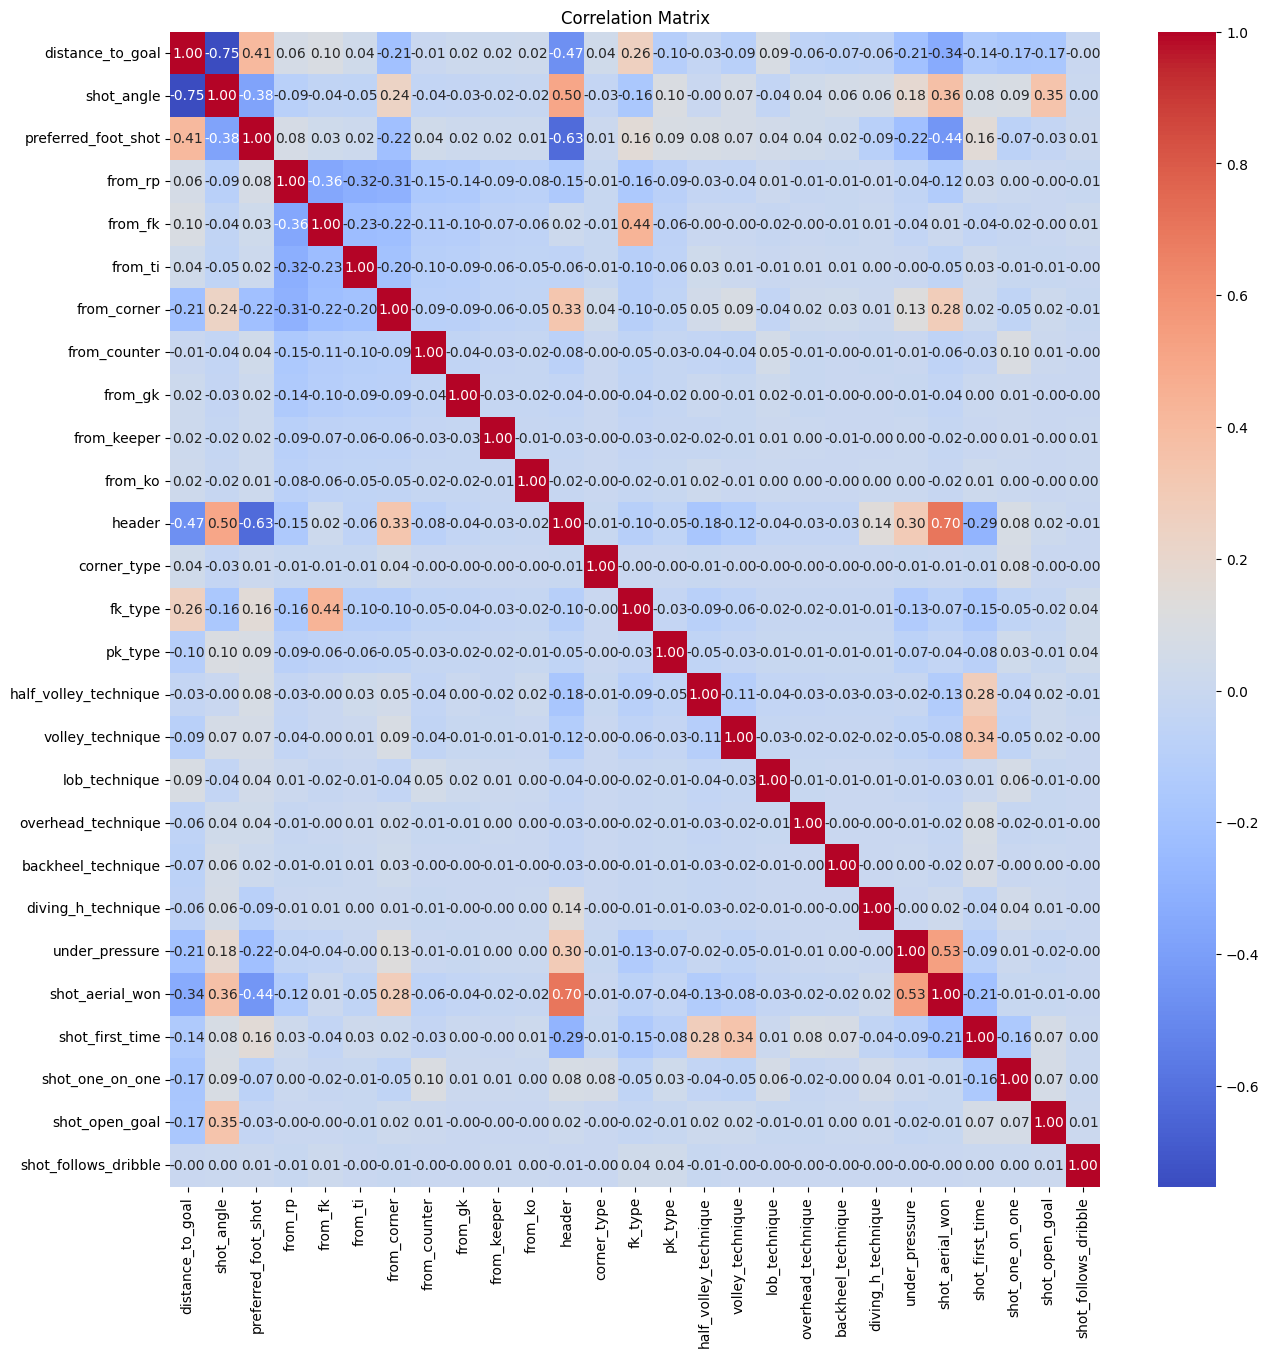

In [10]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=features, yticklabels=features)
plt.title("Correlation Matrix")
plt.show()

## Model Training

In [7]:
# splitting data
train_data, test_data = pp.pre_training(shots,train_size=0.7)

## Regression Logistique

### Training

In [8]:
start_time = time.time()
log_reg = ModelTrainer(train_data,test_data,model_type='logistic',max_iter=100)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Training took 176.04 seconds.


### Evaluation

In [13]:
predictions = pp.goal_proba(log_reg.predictions)
predictions.write.csv('lr_predictions.csv',header=True)
predictions = spark.read.csv('lr_predictions.csv',header=True,inferSchema=True)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [18]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.36,
 'Precision': 68.74,
 'Recall': 20.56,
 'Sensitivity': 20.56,
 'Specificity': 98.86,
 'F1': 31.66,
 'FPR': 1.14,
 'FNR': 79.44}

In [19]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.67,
 'Precision': 83.87,
 'Recall': 77.13,
 'Sensitivity': 77.13,
 'Specificity': 99.46,
 'F1': 80.35,
 'FPR': 0.54,
 'FNR': 22.87}

In [20]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.0037, 'RMSE': 0.06085, 'MAE': 0.03424, 'R2': 83.03}

In [21]:
# Feature importance
print('features')
fi = log_reg.feature_importance()
fi.sort_values(by='Importance',ascending=False)

features


,Feature,Importance
11,pk_type,2.194412
9,corner_type,2.177720
10,fk_type,1.699249
14,lob_technique,0.895473
25,shot_open_goal,0.877785
17,diving_h_technique,0.725343
4,from_counter,0.534679
6,from_keeper,0.341311
20,preferred_foot_shot,0.308018
24,shot_one_on_one,0.269163


## Naive Bayes

In [39]:
start_time = time.time()
nb = ModelTrainer(train_data,test_data,model_type='nb')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Training took 746.4 seconds.


In [59]:
predictions = pp.goal_proba(nb.predictions)
predictions.write.csv('nb_predictions.csv',header=True)
predictions = spark.read.csv('nb_predictions.csv',header=True,inferSchema=True)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 76.51,
 'Precision': 25.58,
 'Recall': 57.98,
 'Sensitivity': 57.98,
 'Specificity': 78.84,
 'F1': 35.5,
 'FPR': 21.16,
 'FNR': 42.02}

In [60]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 78.15,
 'Precision': 13.89,
 'Recall': 97.42,
 'Sensitivity': 97.42,
 'Specificity': 77.43,
 'F1': 24.31,
 'FPR': 22.57,
 'FNR': 2.58}

In [76]:
print('Regression results')
me_r.get_all_metrics()

Regression results

{'MSE': 0.14119, 'RMSE': 0.37575, 'MAE': 0.2193, 'R2': 542.53}


## Decision Tree

In [41]:
start_time = time.time()
dt = ModelTrainer(train_data,test_data,model_type='dt')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Training took 1213.8 seconds.


In [29]:
predictions = pp.goal_proba(dt.predictions)
predictions.write.csv('dt_predictions.csv',header=True)
predictions = spark.read.csv('dt_predictions.csv',header=True,inferSchema=True)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [30]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 89.96,
 'Precision': 71.67,
 'Recall': 16.36,
 'Sensitivity': 16.36,
 'Specificity': 99.19,
 'F1': 26.63,
 'FPR': 0.81,
 'FNR': 83.64}

In [33]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.06,
 'Precision': 82.62,
 'Recall': 58.33,
 'Sensitivity': 58.33,
 'Specificity': 99.54,
 'F1': 68.38,
 'FPR': 0.46,
 'FNR': 41.67}

In [34]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00727, 'RMSE': 0.08526, 'MAE': 0.0484, 'R2': 66.92}

In [35]:
fi_dt = dt.feature_importance()
fi_dt.sort_values(by='Importance',ascending=False)

,Feature,Importance
19,shot_angle,0.394019
8,header,0.200981
18,distance_to_goal,0.117130
25,shot_open_goal,0.116713
11,pk_type,0.104172
24,shot_one_on_one,0.046879
22,shot_aerial_won,0.011056
3,from_corner,0.006698
27,players_inside_area,0.002352
1,from_fk,0.000000


## SVM

In [40]:
start_time = time.time()
svm = ModelTrainer(train_data,test_data,model_type='svm')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Training took 1772.1 seconds.


In [48]:
predictions = svm.predictions
predictions = predictions.withColumnRenamed('rawPrediction','probability')
predictions = pp.goal_proba(predictions)
predictions.write.csv('svm_predictions.csv',header=True)
predictions = spark.read.csv('svm_predictions.csv',header=True,inferSchema=True)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [49]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.07,
 'Precision': 73.98,
 'Recall': 16.85,
 'Sensitivity': 16.85,
 'Specificity': 99.26,
 'F1': 27.44,
 'FPR': 0.74,
 'FNR': 83.15}

In [50]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.47,
 'Precision': 90.75,
 'Recall': 63.94,
 'Sensitivity': 63.94,
 'Specificity': 99.76,
 'F1': 75.02,
 'FPR': 0.24,
 'FNR': 36.06}

In [79]:
print('Regression results')
me_r.get_all_metrics()

Regression results

{'MSE': 1.16644, 'RMSE': 1.08002, 'MAE': 1.06679, 'R2': 5208.42}


In [52]:
fi_svm = svm.feature_importance()
fi_svm.sort_values(by='Importance',ascending=False)

,Feature,Importance
25,shot_open_goal,2.000000e+00
11,pk_type,1.968162e+00
9,corner_type,2.125180e-06
10,fk_type,9.281154e-07
20,preferred_foot_shot,3.849937e-07
14,lob_technique,2.877973e-07
21,under_pressure,1.510668e-07
8,header,3.423637e-08
23,shot_first_time,3.353126e-08
12,half_volley_technique,0.000000e+00


In [69]:
FEATURES = ['from_rp','from_fk','from_ti','from_corner','from_counter','from_gk','from_keeper','from_ko',
            'header','corner_type','fk_type','pk_type',
            'half_volley_technique','volley_technique','lob_technique','overhead_technique','backheel_technique',
            'diving_h_technique',
            'distance_to_goal', 'shot_angle', 'preferred_foot_shot', 'under_pressure',
            'shot_aerial_won','shot_first_time','shot_one_on_one','shot_open_goal','shot_follows_dribble','players_inside_area']

In [71]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, NaiveBayes, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

# Split data
train, test = shots.randomSplit([0.8, 0.2], seed=42)

assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
train = assembler.transform(train)
test = assembler.transform(test)

# Define evaluator for AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol="goal", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [72]:
lr = LogisticRegression(featuresCol="features", labelCol="goal")
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC-ROC: {lr_auc}")

Logistic Regression AUC-ROC: 0.8040863485273682


In [73]:
nb = NaiveBayes(featuresCol="features", labelCol="goal")
nb_model = nb.fit(train)
nb_predictions = nb_model.transform(test)
nb_auc = evaluator.evaluate(nb_predictions)
print(f"Naïve Bayes AUC-ROC: {nb_auc}")

Naïve Bayes AUC-ROC: 0.6749610726643598


In [74]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="goal")
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_auc = evaluator.evaluate(dt_predictions)
print(f"Decision Tree AUC-ROC: {dt_auc}")

Decision Tree AUC-ROC: 0.5330984524425797


In [75]:
svm = LinearSVC(featuresCol="features", labelCol="goal", maxIter=10)
svm_model = svm.fit(train)
svm_predictions = svm_model.transform(test)
svm_auc = evaluator.evaluate(svm_predictions)
print(f"SVM AUC-ROC: {svm_auc}")

SVM AUC-ROC: 0.748943887420647


In [ ]:
spark.stop()